<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/3.0-modeling-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling: regression and linear modeling

This is day 3 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md). To recap from the previous lectures, we have looked at defining the outcome of knee replacement:
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).



## Learning objectives
### Modeling: regression and linear modeling
For this lecture we are going to build various predictors for `t1_eq_vas`, i.e. the reported quality of life after operation. `t1_eq_vas` is measured on a scale from 0 to 100.

We are going to use stratefied sampling to ensure we don't introduce sampling bias, using `StratefiedShuffleSplit`. This is different from the simplest function `train_test_split` which is a random sampling method. This is generally fine if your dataset is large enough (especially relative to the number of attributes). But if it is not, you run the risk of introducing significant sampling bias.

By the end of this lecture you should know:
- Know how to perform different regressions models in Python using scikit-learn
- Know how to interpret and assess regression models, including the bias-variance trade-of



### Python: Hands-on Machine Learning (2nd edition)

- [End-to-end Machine Learning project (chapter 2)](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)
- [Training linear models (chapter 4)](https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb)


### scikit-learn
- [Tutorial cross validation score](https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html?highlight=cross%20validation%20score)

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit


# 999 is used as a sentinel value, replacing those with median
df["t1_eq_vas_impute"] = df.t1_eq_vas.replace(
    to_replace=999, value=np.median(df.t1_eq_vas)
)

# add t1_eq_vas categories
df['t1_eq_vas_cat'] = pd.cut(df.t1_eq_vas_impute, 10)

# Only using 1 split for stratefied sampling, more folds are used later on in cross-validation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['t1_eq_vas_cat']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

# remove columns so we continue working with original dataset
for set_ in (df_train, df_test):
    set_.drop(["t1_eq_vas_impute", "t1_eq_vas_cat"], axis=1, inplace=True)

# Data preparation in a scikit-learn Pipeline
Previously we have already discussed the various steps in data preparation using [pandas](https://pandas.pydata.org/). As explained in the [documentation of scikit-learn](https://scikit-learn.org/stable/modules/compose.html#column-transformer), this may be problematic for one of the following reasons:

* Incorporating statistics from test data into the preprocessors makes cross-validation scores unreliable (known as data leakage), for example in the case of scalers or imputing missing values.

* You may want to include the parameters of the preprocessors in a [parameter search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

To this purpose, the [`ColumnTransformer` class](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer) has been recently added to scikit-learn. The documentation gives an example how to use this for [pre-processing mixed types](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py). Historically, `sklearn` transformers are designed to work with numpy arrays, not with pandas dataframes. You can use [`sklearn-pandas`](https://github.com/scikit-learn-contrib/sklearn-pandas) to bridge this gap or use `ColumnTransformer` directly on pandas DataFrames. We will use the latter.



## Using ColumnsTransformers and Pipelines

Recalling from the second lecture, we want to perform the following preprocessing per (group of) columns. In case feature requires more than one preprocessing step, the use of `Pipeline` is recommended.

### Passing 1D or 2D arrays in your `Pipeline`
It is important to remember that `scikit-learn` can be quite fussy about the difference between passing 1D arrays/series and 2D arrays/dataframes.

For example, the following code will result in an error because `categories` needs to be a list of lists:
```
enc = OrdinalEncoder(categories=age_band_categories)
enc.fit(df[age_band])
```

The correct code is (brackets!):
```
enc = OrdinalEncoder(categories=[age_band_categories])
enc.fit(df[age_band])
```


### Beware: difference between `OrdinalEncoder` and `OneHotEncoding`
Using `OrdinalEncoder` to generate an integer representation of a categorical variable can not be used directly with all scikit-learn estimators, as these expect continuous input, and would interpret the categories as being ordered, which is often not desired.

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K, also known as one-hot or dummy encoding. This type of encoding can be obtained with the OneHotEncoder, which transforms each categorical feature with n_categories possible values into n_categories binary features, with one of them 1, and all others 0.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# group columns
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]
oks_questions = [
    col for col in df.columns if col.startswith("oks_t0") and not col.endswith("_score")
]
oks_score = ["oks_t0_score"]

# preprocessing pipelines for specific columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)

gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                   ('onehot', OneHotEncoder()),
    ]
)


# ColumnTransformer on all included columns.
# Note columns that are not specified are dropped by default
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    "comorb": (
        "comorb",
        SimpleImputer(missing_values=9, strategy="constant", fill_value=0),
        comorb,
    ),
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    "oks": (
        "oks",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        oks_questions,
    ),
    "oks_score": (
        "oks_score",
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        oks_score,
    ),
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}
prep = ColumnTransformer(transformers=[v for _, v in transformers.items()])

X_train = prep.fit_transform(df_train)
X_test = prep.fit_transform(df_test)

In [4]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions
    + oks_score
    + eq_vas
)

### Writing custom transformers (advanced, see Géron chapter 2)
Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

When writing transformers for data preparation, you only need to define `transform()`. Basically, `ColumnTransformer` passes only the subset of columns from the original dataframe to the transformer. So when writing your own transformer you don't need to do any subsetting, but you can assume that the `transform()` method should be applied to the whole dataframe.



In [5]:
# just as an example, not used in Pipeline
class ReplaceSentinels(BaseEstimator, TransformerMixin):
    """Replace sentinel values in dataframe.
    
    Attributes:
        sentinel: sentinel value, default 9
        replace_with: value to replace sentinel with, default np.nan
    """
    def __init__(self, sentinel = 9, replace_with=np.nan):
        self.sentinel = sentinel
        self.replace_with = replace_with
    def fit(self, X, y=None):
        return self
    def transform(self, X, ):
        return X.replace(9, self.replace_with)


## Training and assessing linear models

### Simple regression
Regression of `t1_eq_vas` ~ `t0_eq_vas`. We don't get our hopes up, since the scatterplot is all over the place:

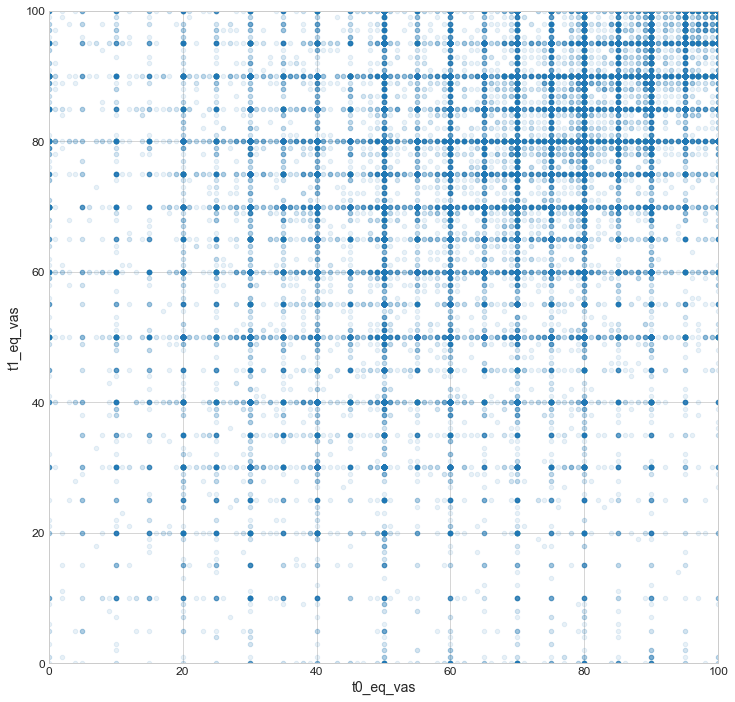

In [6]:
df_train.plot(kind='scatter', x='t0_eq_vas', y='t1_eq_vas', xlim=(0,100), ylim=(0,100), alpha=0.1, figsize=M);

In [7]:
from sklearn.linear_model import LinearRegression


def fill_median(s):
    return s.fillna(value=s.median()).to_frame() 

eq = ['t0_eq_vas', 't1_eq_vas']
eq_prep = ColumnTransformer(transformers=
                            [('eq',
                              SimpleImputer(missing_values=999,
                                            strategy='median'),
                              eq),
                            ])
eq_prep.fit(df_train)

# note y = t1_eq
t0_eq, t1_eq = eq_prep.transform(df_train)[:,0].reshape(-1,1), eq_prep.transform(df_train)[:,1]

# prepare t1_eq_test for use in model assessment
t1_eq_test = eq_prep.transform(df_test)[:,1]

# simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(t0_eq, t1_eq)
lin_reg.intercept_, lin_reg.coef_, lin_reg.score(t0_eq, t1_eq)

(53.96785070807603, array([0.3119393]), 0.11759546401482968)

So this very first, basic model yields an $R^2$ of 0.12 which is not very exciting. Let's do a more robust cross validation using the Mean Square Error (MSE) as our metric

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")

scores = cross_val_score(lin_reg, t0_eq, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [16.66593682 16.82464722 16.87729003 16.88592997 16.93669798]
Mean: 16.8381
Standard deviation: 0.0931


This confirms a simple linear model has little flexibility (and high bias): the scores for the five CV-folds are very similar. Now that we have seen the simplest setup for a univariate lineair regression, let's try to find out which features are the best predictors.

### SelectKBest

For regression tasks, you often want to get a first idea which features contain the most information i.e. are the best predictors. There are various techniques to answer this question, such as stepwise selection. Scikit-learn has various [univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods for this purpose. We will use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).


In [9]:
from sklearn.feature_selection import SelectKBest, f_regression

k10best = Pipeline(
    steps=[
        ("prep", ColumnTransformer(transformers=transformers.values())),
        ("kbest", SelectKBest(f_regression, k=10)),
#         ("lin_reg", LinearRegression())
    ]
)

X_10best = k10best.fit(df_train, t1_eq).transform(df_train)
lin_10best = LinearRegression()
scores_10best = cross_val_score(lin_10best, X_10best, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_10best_rmse_scores = np.sqrt(-scores_10best)
display_scores(lin_10best_rmse_scores)

Scores: [15.99162775 16.14324365 16.17794808 16.22819153 16.19174312]
Mean: 16.1466
Standard deviation: 0.0821


Using 10 KBest features, the model performs slightly better with RMSE of 16.1 +/- 0.08

In [10]:
# show features in descending order of importance
pd.concat(
        {"score": pd.Series(k10best["kbest"].scores_), "feature": X_columns}, axis=1
    ).sort_values("score", ascending=False)


,score,feature
39,12988.61,t0_eq_vas
38,8612.77,oks_t0_score
36,8036.19,oks_t0_shopping
19,7386.24,t0_self_care
17,6930.16,t0_disability
28,6620.98,oks_t0_washing
22,6559.51,t0_anxiety
37,5421.20,oks_t0_stairs
34,5213.64,oks_t0_work
29,4438.80,oks_t0_transport


### Regularized linear models: Lasso regression

Construct a Lasso regression with cross-validation, following the example from [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py). Recall that for regularized linear regression a cost function is added. In case of Lasso this is

$$ J(\Theta) = MSE (\Theta) + \alpha\sum\limits_{i=1}^n \mid{\Theta_{i}}\mid$$

The larger $\alpha$, the larger the penalty and hence more coefficients will be set to zero. By default `LassoCV` tries 100 different values for $\alpha$ so let's plot MSE against $\alpha$:

In [11]:
from sklearn.linear_model import LassoCV

# This is to avoid division by zero while doing np.log10
EPSILON = 1e-4

lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train, t1_eq)

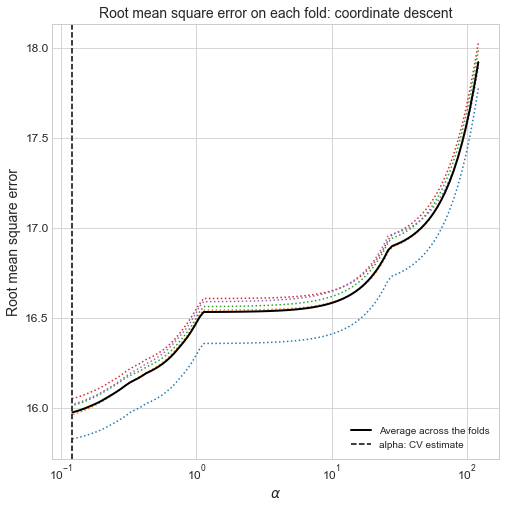

In [12]:
plt.figure(figsize=S)
plt.semilogx(lasso.alphas_ + EPSILON, np.sqrt(lasso.mse_path_), ":")
plt.plot(
    lasso.alphas_ + EPSILON,
    np.sqrt(lasso.mse_path_.mean(axis=-1)),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel("Root mean square error")
plt.title("Root mean square error on each fold: coordinate descent")
plt.axis("tight");

The Lasso model performs best for lowest $\alpha$

In [13]:
print("Best Lasso model:\n"
      f"  RMSE: {np.sqrt(mean_squared_error(lasso.predict(X_train), t1_eq)):.2f}\n"
      f"  intercept: {lasso.intercept_:.2f}")

Best Lasso model:
  RMSE: 15.97
  intercept: 55.62


Inspect the relative feature importance by looking at the (absolute) coefficients:

In [14]:
pd.concat({'coef_abs': pd.Series(abs(lasso.coef_)), 'coef': pd.Series(lasso.coef_), 'feature': X_columns}, axis=1).sort_values('coef_abs', ascending=False)

,coef_abs,coef,feature
17,3.57,3.57,t0_disability
13,2.99,-2.99,depression
19,2.34,-2.34,t0_self_care
22,2.21,-2.21,t0_anxiety
7,2.06,-2.06,lung_disease
3,1.77,-1.77,heart_disease
6,1.46,-1.46,circulation
8,1.32,-1.32,diabetes
32,1.07,-1.07,oks_t0_limping
36,0.74,0.74,oks_t0_shopping


In [17]:
# final test
print(f"MSE from training with CV: {np.sqrt(mean_squared_error(lasso.predict(X_train), t1_eq)):.2f}\n"
      f"MSE test: {np.sqrt(mean_squared_error(lasso.predict(X_test), t1_eq_test)):.2f}")

MSE from training with CV: 15.97
MSE test: 15.98


### KNN

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from collections import defaultdict

n_neighbors = [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300]
knn = defaultdict(dict) # use defaultdict for nested dicts
for n in n_neighbors:
    knn[n]["model"] = KNeighborsRegressor(n_neighbors=n, n_jobs=-1).fit(X_train, t1_eq)
    knn[n]["cross validation scores"] = cross_val_score(
        knn[n]["model"], X_train, t1_eq, scoring="neg_mean_squared_error", cv=5
    )

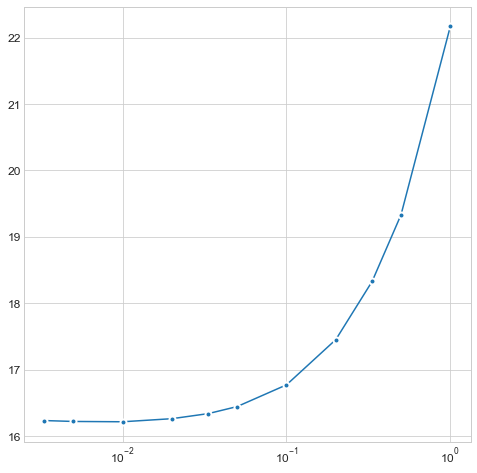

In [19]:
# plot 1/K vs. error rate just like in ISLR figure 3.19 (p. 108)
knn_mse = [np.sqrt(np.mean(-knn[n]['cross validation scores'])) for n in n_neighbors]
plt.figure(figsize=S)
plt.semilogx([1/n for n in n_neighbors], knn_mse, 'o-', markeredgecolor='w', markeredgewidth='2');

In [20]:
# minimum RMSE is 16.2 at 1/K = 10-2, i.e. n=100
knn_mse

[22.166836606847422,
 19.331823949816446,
 18.330914652142457,
 17.45471210321926,
 16.77413895403912,
 16.447539274041524,
 16.341569911567717,
 16.26510573367967,
 16.218694035023702,
 16.223424483568255,
 16.236967781806584]

In [21]:
# final test
print(f"{np.sqrt(mean_squared_error(knn[100]['model'].predict(X_test), t1_eq_test)):.4f}")    

16.2473


### RandomForest regression
_consider this as a sneak preview for the next lecture, where we will use RandomForest for classification_

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, t1_eq)
rf_crosscv = cross_val_score(rf_reg, X_train, t1_eq, scoring="neg_mean_squared_error", cv=5)

In [23]:
print(f"{np.sqrt(np.mean(-rf_crosscv)):.4f}")

16.1322


In [24]:
# final test
print(f"{np.sqrt(mean_squared_error(rf_reg.predict(X_test), t1_eq_test)):.4f}")    

16.1506


That looks promising: out-of-the-box RandomForest performs better than KNN (but slightly worse than Lasso). Like Lasso, we can inspect feature importance:

In [25]:
pd.concat(
    {"feature": X_columns, "importance": pd.Series(rf_reg.feature_importances_)}, axis=1
).sort_values("importance", ascending=False)

,feature,importance
39,t0_eq_vas,1.64e-01
38,oks_t0_score,8.55e-02
19,t0_self_care,4.29e-02
0,age_band,4.08e-02
35,oks_t0_confidence,3.99e-02
30,oks_t0_walking,3.84e-02
23,t0_symptom_period,3.70e-02
27,oks_t0_night_pain,3.47e-02
36,oks_t0_shopping,3.39e-02
28,oks_t0_washing,3.32e-02


## Discussion & summary

### For discussion
- Which model would you choose to predict `t1_eq_vas_` and why?
- Reflect on the differences in feature importance between SelectKBest, Lasso coefficients and RandomForest
  - See, for example, [this discussion](https://datascience.stackexchange.com/questions/12148/feature-importance-via-random-forest-and-linear-regression-are-different)



### Summary (from lecture 3)
We have considered three basic machine learning algorithms:
- (Simple) linear regression
- LASSO
- KNN

A regression is often used as a baseline model, whereas LASSO and KNN are expected to have better performance. An obvious starting strategy, would be to: 
- Run a regression to get a baseline performance
- Run LASSO and compare performance
- With the selected variables in your LASSO, run KNN and compare performance

